In [42]:
import os
import sklearn
import sys, copy
import pandas as pd
import numpy as np
import matplotlib as plt
sys.path.append('/Users/pradeepkumar/PycharmProjects/QTW/venv/lib/python3.7/site-packages/')
sys.path.append('/Users/pradeepkumar/PycharmProjects/flask/venv/lib/python3.7/site-packages')

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
import sklearn
import nltk
import string
import glob
import re
import json
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [45]:
# Remove all modified files
mod_files=glob.glob('*.modified')
for efile in mod_files:
    #print(efile)
    os.remove(efile)
    

In [46]:
os.getcwd()

'/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/spam'

## Data PreProcessing

#### The ham and spam mails are processed as follows <br> Emails have header and message body content. Each email is split into header and body. <br> All text above the subject line is considered as header and text below subject is considered as body. <br> Punctiations and stop words are removed <br> Stemming is done to extract the base words 


In [47]:
porter = PorterStemmer()

def remove_punct(s1):
    n = ''
    for c in s1:
        if c not in string.punctuation:
            n += c
        else:
            n += ' '
    return n

def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    
    filtered_sentence = [w for w in words if not w.lower() in stop_words]
    stemmed_sentence = [porter.stem(w) for w in words]
    
    return ' '.join(stemmed_sentence)
    

def split_header(msg):
    msg_dict = dict()
    
    m1 = re.search('(.*)(subject\s*:.*)', msg, re.I)
    if m1:
        header = m1.group(1).lower()
        body = m1.group(2).lower()
        
        new_header = word_tokenize(remove_punct(header))
        new_body = word_tokenize(remove_punct(body))
        
        new_header1 = remove_stopwords(new_header)
        new_body1 = remove_stopwords(new_body)
        
        
        msg_dict['header'] = new_header1.lower()
        msg_dict['body'] = new_body1.lower()
        
    
    return msg_dict
        

In [48]:
# Seperate the header and message
pdir = ['/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/easy_ham',
        '/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/spam']

for dname in pdir:
    os.chdir(dname)


    all_files = os.listdir()

    for efile in all_files:
        fhw = open(efile+'.modified', mode='w')
    
        full_msg =''
        with open(efile, mode='r', encoding='ascii', errors='ignore') as fh:
            for line in fh:
                full_msg += line.replace('\n',' ')
        
            msg_dict = split_header(full_msg)
            fhw.write(json.dumps(msg_dict))
    
        fhw.close()
        fh.close()
        
            


In [49]:
pdir = ['/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/easy_ham',
        '/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/spam']

ham_headers = list()
spam_headers = list()
ham_body = list()
spam_body = list()

data_dict = dict()
ind=0
for dname in pdir:
    if 'spam' in dname:
        header = spam_headers
        body = spam_body
        key = 'spam'
    if 'easy_ham' in dname:
        header = ham_headers
        body = ham_body
        key = 'ham'
        
    os.chdir(dname)
    mod_files=glob.glob('*.modified')
    
    for efile in mod_files:
        with open(efile) as fh:
            txt = json.load(fh)
            data_dict[key+str(ind)]=txt
            ind += 1
            
 
df = pd.DataFrame.from_dict(data_dict)
            

#### Add a new target column with 1 for spam and 0 for ham 

In [81]:
df1 = df.T
target = df.T.index.tolist()
new_target = list()
for e in target:
    if 'spam' in e:
        new_target.append(1)
    else:
        new_target.append(0)

new_target

df1['target'] = new_target
print(df1.shape)
print(len(new_target))

(7448, 3)
7448


In [82]:
df1

,header,body,target
ham0,from exmh user admin redhat com tue sep 10 11 ...,subject re sort in repli to 200209092111 g89lb...,0
ham1,from sentto 2242572 55912 1033991494 zzzz spam...,subject zzzzteana re megalithomania unpissup r...,0
ham2,from sentto 2242572 56001 1034049352 zzzz spam...,subject re zzzzteana good isp for mac repli to...,0
ham3,from spamassassin talk admin list sourceforg n...,subject satalk re custom action for high score...,0
ham4,from spamassassin talk admin list sourceforg n...,subject satalk run sa as a user app sender spa...,0
...,...,...,...
spam7443,from dlpost34 yahoo com wed aug 1 06 44 03 200...,subject home loan just got better date wed 01 ...,1
spam7444,from pdibeta gmx net fri sep 6 15 40 52 2002 r...,subject intern call for onli 33 cent per minut...,1
spam7445,from ilug admin linux ie sat sep 21 10 48 43 2...,subject ilug garden ornament mvcmv sender ilug...,1
spam7446,from tba insurancemail net mon jun 24 17 04 15...,subject 9 05 guarante annuiti 8 commiss to yyy...,1


### Convert the header and body text to Tf-Idf scores. <br> The output of Tf-Idf vector is a large sparse matrix


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=None, use_idf=True, norm=None)
tfidf_headers = vectorizer.fit_transform(df1.header)

tfidf_body = vectorizer.fit_transform(df1.body)


### Reduce the dimension of the sparse Tf-Idf matrix before training the model 

In [84]:
tfidf_headers.shape
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
tfidf_headers_trans = svd.fit_transform(tfidf_headers)


### After dimension reduction, With 15 components , we can explain up to 69% of variance.

In [85]:
svd1 = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
tfidf_body_trans = svd1.fit_transform(tfidf_body)
print(svd1.explained_variance_ratio_.sum())

0.6939943139319408


### Check for clustering in data with Hierarchical Clustering Algorithm as below <br> Capping the level of tree at 4, we can see that there are 3 cluster identified based on distances between the Tf-Idf scores of each email body

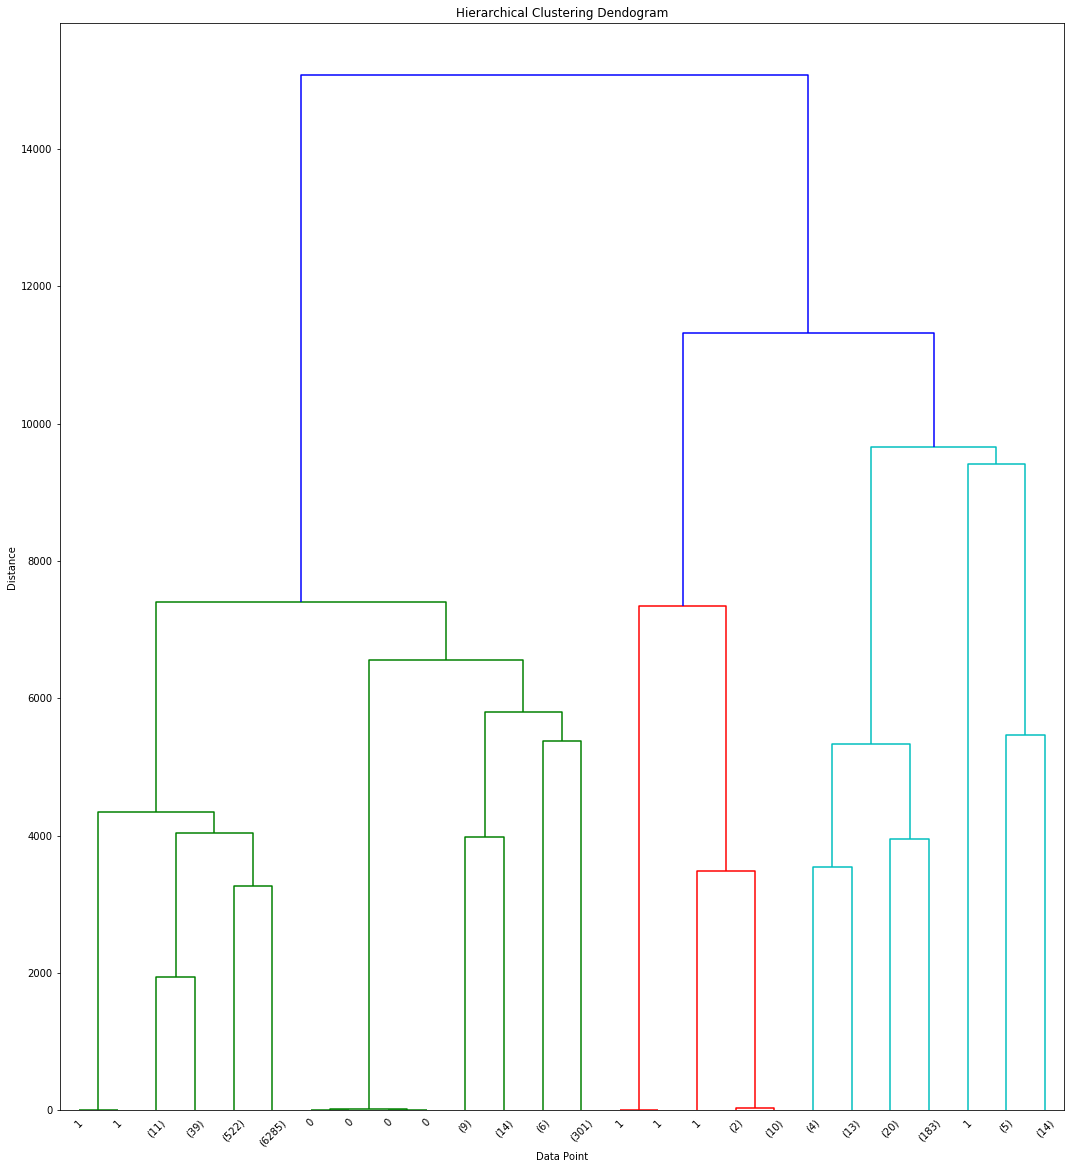

In [86]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(tfidf_body_trans, 'ward')

import matplotlib.pyplot as plt
plt.figure(figsize=(18,20))
plt.title('Hierarchical Clustering Dendogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(Z, labels=df1.target, p=4, truncate_mode='level', orientation='top')
plt.show()


### With Kmeans clustring, by setting k=2, we can see 2 cluster by using the first 2 dimensions only. <br> There is no clear seperation of data in this cluster

Text(0.5, 1.0, 'Spam and Ham email clusters')

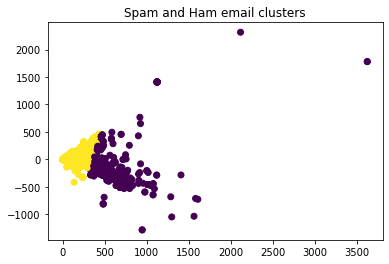

In [87]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(tfidf_body_trans)

plt.scatter(tfidf_body_trans[:, 0], tfidf_body_trans[:, 1], c=y_pred)
plt.title("Spam and Ham email clusters")


<b> Checking for correlation between features </b> <br> <i> From the heat map below , we can see that there is no correlation <br> between features </i>

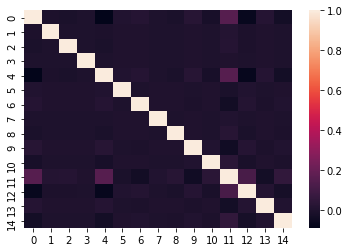

In [183]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
corr = np.corrcoef(tfidf_body_trans, rowvar=False)
corr.shape
sns.heatmap(corr)

<b> Build a Naive Bayes Classifier </b> <br>
<i> Naive Bayes assumes that features are independent which is proved in the heat map above.  30% of data is used for test purpose </i>


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(tfidf_body_trans, df1.target, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 3724 points : 676


In [134]:
X_test.shape

(3724, 15)

In [94]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8184747583243824


In [126]:
# Prediction on a Spam Email 
efile = "/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/spam/0500.2e8762b67913d1b07bc8da293448d27f"
with open(efile, mode='r', encoding='ascii', errors='ignore') as fh:
    for line in fh:
        full_msg += line.replace('\n',' ')
        
    msg_dict = split_header(full_msg)
    
spam_mail_body = msg_dict['body']

# Make the sample spam mail part of the corpus of emails to get the Tf-Idf score
df_sample = df1.body.values.tolist()
#print(type(df_sample))
df_sample.append(spam_mail_body)

vectorizer = TfidfVectorizer(stop_words=None, use_idf=True, norm=None)
tfidf_sample_spam = vectorizer.fit_transform(df_sample)

#tfidf_sample_spam.shape
svd2 = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
tfidf_sample_trans = svd2.fit_transform(tfidf_sample_spam)


In [136]:
X_samp = tfidf_sample_trans[-1]

In [153]:
tfidf_sample_trans.shape

(7449, 15)

In [156]:
X_samp = X_samp.T
type(X_samp)
B = np.reshape(X_samp, (-1, 1))


X1 = np.ndarray.transpose(B)
X1.shape
#X_samp.shape
#X_samp

(1, 15)

In [157]:
gnb.predict(X1)

array([0])